# PileUp Mitigation with Machine Learning (PUMML)

<a href="https://link.springer.com/article/10.1007%2FJHEP12%282017%29051"> P. T. Komiske, E. M. Metodiev, B. Nachman, and M. D. Schwartz, *JHEP* 1712 (2017) 051</a>

## Imports

In [1]:
# python standard library imports
import os

# external library imports
import h5py
import numpy as np
import matplotlib.pyplot as plt

## Read Files

In [2]:
# path to directory containing downloaded .h5 files
pumml_path = '/Users/pkomiske/Documents/Research/PUMML/events'

# events by different number of pileup interactions (mu)
events_by_mu = h5py.File(os.path.join(pumml_path, 'PUMMLEventsByMu_mH500.h5'))

# events by a different mass (mH) of the scaler resonance
events_by_mh = h5py.File(os.path.join(pumml_path, 'PUMMLEventsBymH_Mu140.h5'))

In [3]:
# print 10 items from mu file
events_by_mu.items()[:10]

[(u'0', <HDF5 dataset "0": shape (2000, 110, 9), type "<f4">),
 (u'1', <HDF5 dataset "1": shape (2000, 128, 9), type "<f4">),
 (u'10', <HDF5 dataset "10": shape (2000, 154, 9), type "<f4">),
 (u'100', <HDF5 dataset "100": shape (2000, 516, 9), type "<f4">),
 (u'101', <HDF5 dataset "101": shape (2000, 558, 9), type "<f4">),
 (u'102', <HDF5 dataset "102": shape (2000, 547, 9), type "<f4">),
 (u'103', <HDF5 dataset "103": shape (2000, 552, 9), type "<f4">),
 (u'104', <HDF5 dataset "104": shape (2000, 604, 9), type "<f4">),
 (u'105', <HDF5 dataset "105": shape (2000, 541, 9), type "<f4">),
 (u'106', <HDF5 dataset "106": shape (2000, 598, 9), type "<f4">)]

In [4]:
# print items from mh fle
events_by_mh.items()

[(u'200', <HDF5 dataset "200": shape (50000, 704, 9), type "<f4">),
 (u'2000', <HDF5 dataset "2000": shape (50000, 876, 9), type "<f4">),
 (u'300', <HDF5 dataset "300": shape (50000, 744, 9), type "<f4">),
 (u'500', <HDF5 dataset "500": shape (50000, 757, 9), type "<f4">),
 (u'700', <HDF5 dataset "700": shape (50000, 774, 9), type "<f4">),
 (u'900', <HDF5 dataset "900": shape (50000, 783, 9), type "<f4">)]

## Datasets

Each dataset in the h5py files contains a specific number of events, 2k for each dataset specified by $\mu$ and 50k for each dataset specified by $m_H$. Each event is padded with zero-particles such that all events can fit in a single contiguous numpy array. Note that when using the datasets, you may want to get rid of these zero particles. There are 9 features per particle, which are described below. Note that only particles which appear in some jet are present.

In the examples below, you can see that there are 2000 events in the $\mu=42$ dataset, the maximum number of particles recorded in a single event was 304 so all events are zero-padded to match that, and there are 9 features per particle.

In [5]:
# get events by a specific mu value
events_mu_42 = events_by_mu['42']

# events_mu_42 is an h5py Dataset which behaves like a numpy array
print(type(events_mu_42), events_mu_42.shape)

# but you can get an actual numpy array (this involves actually reading data from disk and loading it into memory)
events_mu_42_ndarray = events_mu_42[()]
print(type(events_mu_42_ndarray), events_mu_42_ndarray.shape)

(<class 'h5py._hl.dataset.Dataset'>, (2000, 304, 9))
(<type 'numpy.ndarray'>, (2000, 304, 9))


The two humps in the following plot are due to some events having only one jet present.

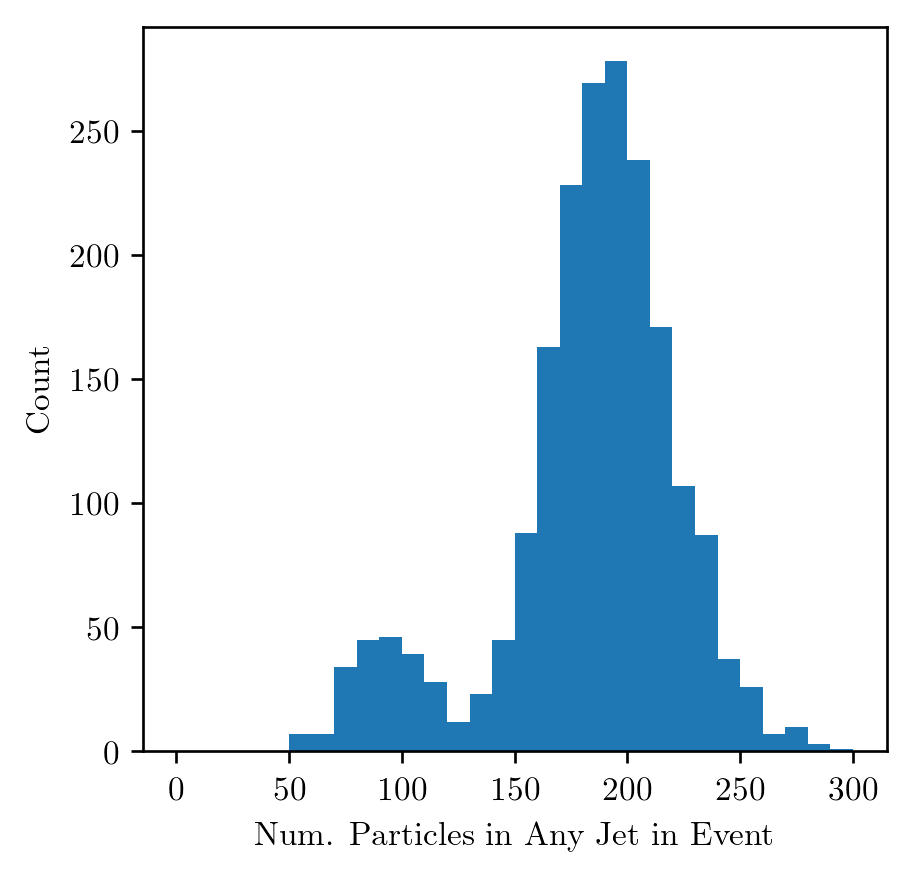

In [6]:
# demonstrating the non-zero padded multiplicity of the events
plt.hist([np.count_nonzero(event[:,0] > 0) for event in events_mu_42_ndarray], bins=np.arange(0, 305, 10))
plt.xlabel('Num. Particles in Any Jet in Event')
plt.ylabel('Count')
plt.show()

## Particle Attributes

In [7]:
# this names the 9 features of each particle entry
events_by_mu.attrs['col_names']

array(['pt', 'eta', 'phi', 'charged', 'vertex', 'puppi_weight',
       'sk_weight', 'truth_jet', 'reco_jet'], dtype='|S12')

The columns of each event are as follows:

- **pt** - Transverse momentum of the particle, in GeV
- **eta** - Pseudorapidity of the particle, in GeV
- **phi** - Azimuthal angle of the particle (be careful about phi being periodic!)
- **charged** - 0 for neutral particles and 1 for charged particles
- **vertex** - Vertex id for the particle, 0 is the leading vertex and > 0 is pileup
- **puppi_weight** - PUPPI weight for the particle, using the parameters described in the PUMML paper
- **sk_weight** - SoftKiller weight for the particle, using the parameters described in the PUMML paper
- **truth_jet** - 0 if particle is in the hardest truth (found without pileup) LV jet, 1 if in second hardest LV jet (some events may not have a second hardest LV jet due to not passing kinematic cuts), and -1 if particle is not in an LV jet
- **reco_jet** - 0 if particle is in reco (found with pileup) jet corresponding to hardest LV jet, 1 if in reco jet corresponding to second hardest LV jet, and -1 if particle is not in any reco jet (rare)

Note that events may have one or two jets, depending on how many LV jets passed kinematic cuts. We do not record events that had no LV jets passing.

## Extracting Jets

In [8]:
# get all truth jets from mu=42 dataset
mu_42_jets = []

# index of truth jet index
tjet_i = 7

# iterate over events
for event in events_mu_42_ndarray:
    
    # get nonzero particles from events
    particles = event[event[:,0] > 0]
    
    # upt to two total jets
    for tjet in range(2):
        
        # get particles matching that truth jet
        jet = particles[particles[:,tjet_i] == tjet]
        
        # append if we have some particles
        if len(jet) > 0:
            mu_42_jets.append(jet)

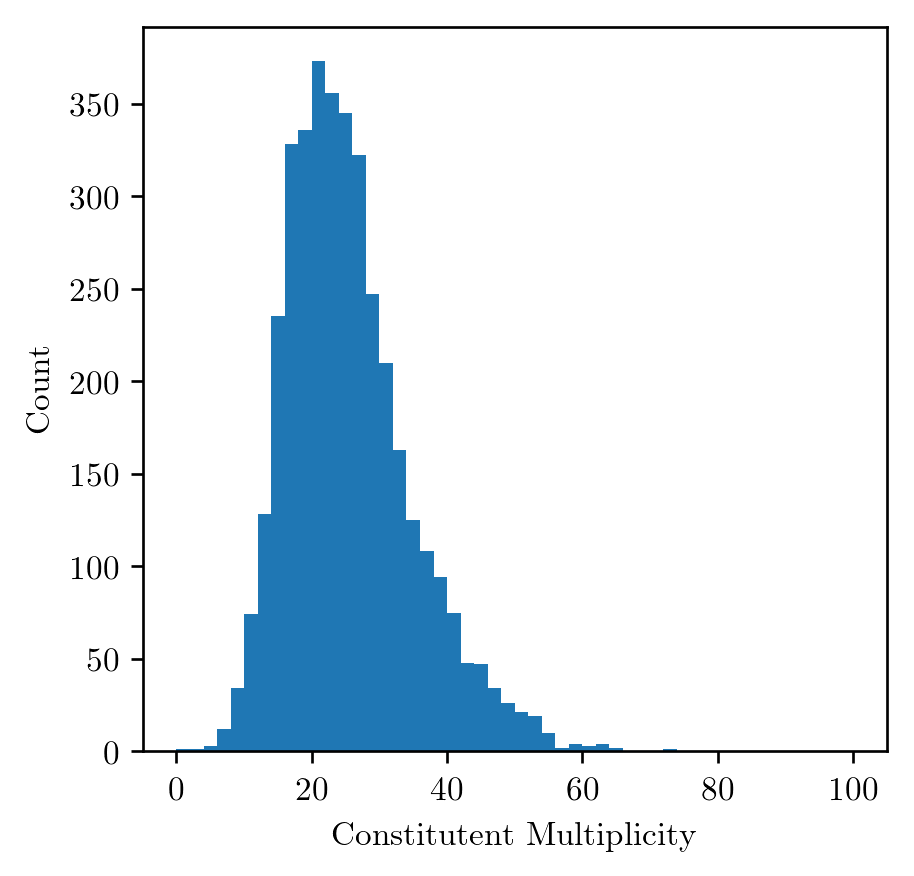

In [9]:
# get multiplicity spectrum of mu=42 jets
plt.hist([len(jet) for jet in mu_42_jets], bins=np.arange(0, 101, 2))
plt.xlabel('Constitutent Multiplicity')
plt.ylabel('Count')
plt.show()